<a href="https://colab.research.google.com/github/seoirsem/Colab_Notebooks/blob/main/Modular_Addition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00


In [2]:
pip install transformer_lens

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import time
import random
import math
import einops
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer

from typing import List, Union, Optional


In [4]:
def timer(fn):
  def wrapper(*args, **kwargs):
    t_start = time.time()
    out = fn(*args, **kwargs)
    t_elapsed = time.time() - t_start
    print('The function "{}" took {}s to run'.format(fn.__name__,str(round(t_elapsed,3))))
    return out
  return(wrapper)

In [5]:
####### constants #########
frac_train = 0.7
p = 113
seed = 555
lr = 1e-3
wd = 1.
betas = (0.9,0.98)




In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
a_vector = einops.repeat(torch.arange(p), "i -> (i j)", j=p)
b_vector = einops.repeat(torch.arange(p), "j -> (i j)", i=p)
dataset = torch.stack([a_vector, b_vector], dim=1).to(device)
labels = (dataset[:, 0] + dataset[:, 1]) % p

#labels = torch.zeros([dataset.shape[0],113])
#for i in range(dataset.shape[0]):
  #print(dataset[i, 0].item(), dataset[i, 1].item(), (((dataset[i, 0] + dataset[i, 1]) % p)).item())
 # labels[i,((dataset[i, 0] + dataset[i, 1]) % p).item()] = 1
#labels = (dataset[:, 0] + dataset[:, 1]) % p
labels = labels.to(device)
print(dataset[:5])
print(dataset.shape)
print(labels[:5])
print(labels.shape)

tensor([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 4]], device='cuda:0')
torch.Size([12769, 2])
tensor([0, 1, 2, 3, 4], device='cuda:0')
torch.Size([12769])


In [8]:
@timer
def test_train_split(data, classes, random_seed : int, p_train : float):
  indices = list(range(len(data)))
  np.random.seed(random_seed)
  np.random.shuffle(indices)
  split_index = math.ceil(len(data) * (1-p_train))
  i_train = indices[:split_index]
  i_test = indices[split_index:]
  train_data = data[i_train]
  train_labels = classes[i_train]
  test_data = data[i_test]
  test_labels = classes[i_test]
  return train_data, train_labels, test_data, test_labels

In [9]:
def run_test_set(test_data, test_labels, model):
    model.eval()
    pred = model(test_data)
    n = pred.shape[0]
    count_correct = 0
    for i in range(n):
        top_values, top_indices = torch.topk(pred[i],2)
        label = torch.argmax(test_labels[i])
        count_correct += int(top_indices[0] == label)
    model.train()
    return count_correct/n

In [10]:

cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 4,
    d_model = 128,
    d_head = 32,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=p,
    d_vocab_out=p,
    n_ctx=2,
    init_weights=True,
    device=device,#"cuda",
    seed = 999,
)


In [11]:
class Model(nn.Module):
    def __init__(self, l_in, l_mid, l_out):
        super(Model,self).__init__()


        self.network_seq = nn.Sequential(
        nn.Linear(l_in,l_mid),
        nn.ReLU(),
        nn.Linear(l_mid, l_mid),
        nn.ReLU(),
        nn.Linear(l_mid,l_out),
        nn.Softmax()
        )

    def forward(self, x):
      out = self.network_seq(x)
      return out

In [12]:
train_data, train_labels, test_data, test_labels = test_train_split(dataset, labels, seed, frac_train)
train_data = train_data
train_labels = train_labels
test_data = test_data
test_labels = test_labels
print(train_data[:5])
print(train_labels[:2])


The function "test_train_split" took 0.019s to run
tensor([[110,   3],
        [ 21, 107],
        [102,   8],
        [  7,  86],
        [ 45,  11]], device='cuda:0')
tensor([ 0, 15], device='cuda:0')


In [13]:
def loss_fn(logits, labels):
    if len(logits.shape)==3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])[:, 0]
    return -correct_log_probs.mean()

def run_test(test_data, test_labels, model):
  model.eval()
  pred = model(test_data)
  if len(pred.shape)==3:
      pred = pred[:, -1]
  #print(pred.shape)#.log_softmax(dim=-1)
  n = pred.shape[0]
  count_correct = 0
  for i in range(n):
      top_index = torch.argmax(pred[i])
      #label = torch.argmax(test_labels[i])
      #print(test_labels[i])
      #print(top_index,label)
      #if i == 3:
       # break
      count_correct += int(top_index == test_labels[i])
  model.train()
  return count_correct/n

model = HookedTransformer(cfg)#Model(2,512,113).to(device)
loss_function = loss_fn#nn.BCELoss()
optimiser = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)

for name, param in model.named_parameters():
    if "b_" in name:
        param.requires_grad = False

run_test(test_data,test_labels,model)


0.009286193779368986

In [14]:
model(train_data)[0]
print(train_data.shape)
print(model(train_data).shape)
print(torch.squeeze(model(train_data)).shape)
print(torch.squeeze(model(train_data))[:, -1].shape)
#print(math.log(113))
loss_function(torch.squeeze(model(train_data)),train_labels)

torch.Size([3831, 2])
torch.Size([3831, 2, 113])
torch.Size([3831, 2, 113])
torch.Size([3831, 113])


tensor(4.7357, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)

In [15]:
losses = []
correct_in_test = []
correct_in_train = []
test_losses = []

In [99]:
epochs = 10000
n_show = 1000
n_train_loss = 50

In [100]:
start = time.time()
for i in range(epochs):
    optimiser.zero_grad()
    yPrediction = torch.squeeze(model(train_data))
    #print(yPrediction.shape, train_labels.shape)
    #print(yPrediction[0],data[1][0])
    loss = loss_function(yPrediction, train_labels)
    loss.backward()
    optimiser.step()
    losses.append(loss.item())
   # print(yPrediction.shape)
   # print(train_labels.shape)
    if (i+1) % n_train_loss == 0:
      test_losses.append(loss_function(torch.squeeze(model(test_data)),test_labels).item())
    if (i+1) % n_show == 0:
        correct_in_test.append(run_test(test_data, test_labels,model))
        correct_in_train.append(run_test(train_data, train_labels,model))
        print('Epoch [{}/{}] in {:.2f}s, log loss of {:.3f}, train_set: {:.1f}%, test_set: {:.1f}%'.format(i+1,epochs,time.time()-start,math.log(losses[-1]),100*correct_in_train[-1],100*correct_in_test[-1]))
        start = time.time()


Epoch [1000/10000] in 9.57s, log loss of -12.026, train_set: 100.0%, test_set: 1.9%
Epoch [2000/10000] in 9.64s, log loss of -14.880, train_set: 100.0%, test_set: 3.8%
Epoch [3000/10000] in 9.53s, log loss of -14.971, train_set: 100.0%, test_set: 7.6%
Epoch [4000/10000] in 9.59s, log loss of -15.107, train_set: 100.0%, test_set: 20.6%
Epoch [5000/10000] in 9.69s, log loss of -15.630, train_set: 100.0%, test_set: 94.9%
Epoch [6000/10000] in 9.70s, log loss of -16.051, train_set: 100.0%, test_set: 100.0%
Epoch [7000/10000] in 9.86s, log loss of -16.093, train_set: 100.0%, test_set: 100.0%
Epoch [8000/10000] in 10.40s, log loss of -16.108, train_set: 100.0%, test_set: 100.0%
Epoch [9000/10000] in 9.91s, log loss of -16.116, train_set: 100.0%, test_set: 100.0%
Epoch [10000/10000] in 9.85s, log loss of -16.121, train_set: 100.0%, test_set: 100.0%


# Plot outputs

In [102]:
print(train_data[:10])
print(train_labels[:10])
#print(model(train_data)[1])
print(torch.argmax(model(train_data)[1][0]))


tensor([[110,   3],
        [ 21, 107],
        [102,   8],
        [  7,  86],
        [ 45,  11],
        [ 40, 112],
        [ 79,  92],
        [ 55,  98],
        [ 24,  28],
        [ 96,  84]], device='cuda:0')
tensor([  0,  15, 110,  93,  56,  39,  58,  40,  52,  67], device='cuda:0')
tensor(42, device='cuda:0')


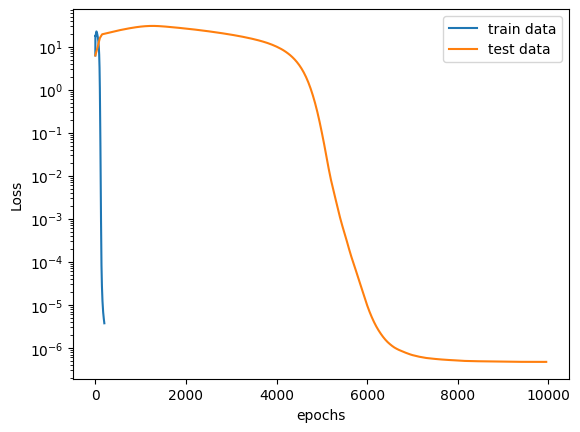

In [103]:
plt.plot(losses, label = 'train data')
plt.plot([n_train_loss*i for i in range(len(test_losses))],test_losses, label = 'test data')
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

Text(0, 0.5, 'Proportion Correct')

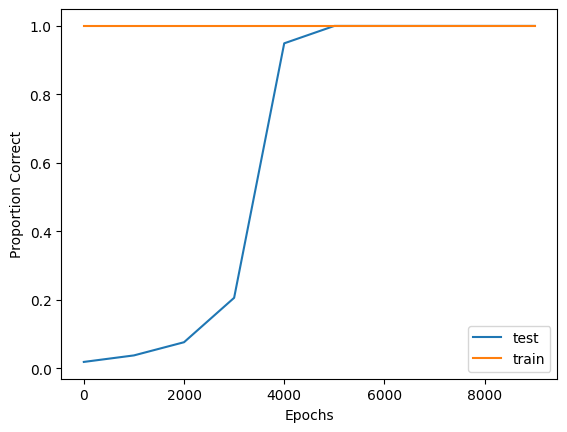

In [104]:
plt.figure()
plt.plot([i*n_show for i in range(len(correct_in_test))],correct_in_test, label = 'test')
plt.plot([i*n_show for i in range(len(correct_in_test))],correct_in_train, label = 'train')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Proportion Correct')

# Looking at the model


In [21]:
original_logits, cache = model.run_with_cache(dataset)
#cache = cache.cpu()

In [96]:
W_E = model.embed.W_E[:-1]
print("W_E", W_E.shape)
W_neur = W_E @ model.blocks[0].attn.W_V @ model.blocks[0].attn.W_O @ model.blocks[0].mlp.W_in
print("W_neur", W_neur.shape)
W_logit = model.blocks[0].mlp.W_out @ model.unembed.W_U
print("W_logit", W_logit.shape)

W_E torch.Size([112, 128])
W_neur torch.Size([4, 112, 512])
W_logit torch.Size([512, 113])


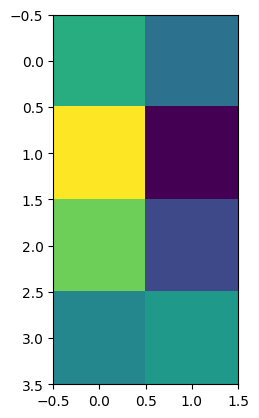

In [97]:
plt.imshow(cache["pattern", 0].mean(dim=0)[:, -1, :].cpu())

## SVD

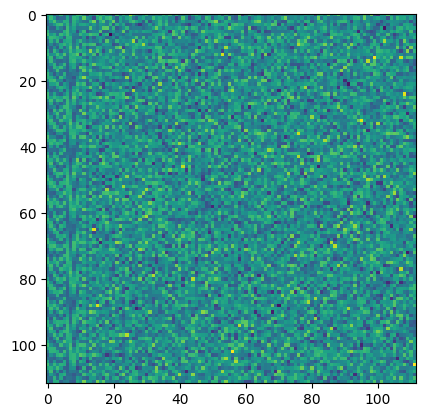

In [105]:
U, S, Vh = torch.svd(W_E)
#plt.line(S, title="Singular Values")
plt.imshow(U.detach().cpu())

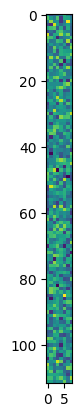

In [93]:
plt.imshow(U.detach().cpu()[:,:8])


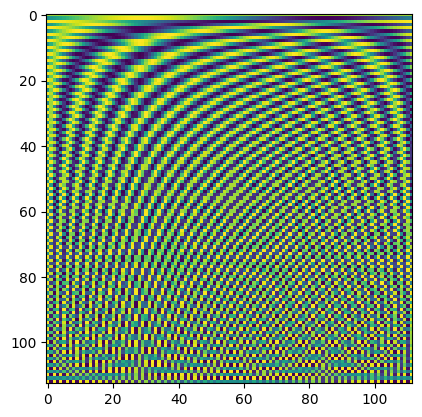

In [107]:
fourier_basis = []
#p = 113
fourier_basis_names = []
fourier_basis.append(torch.ones(p-1))
fourier_basis_names.append("Constant")
for freq in range(1, p//2+1):
    fourier_basis.append(torch.sin(torch.arange(p-1)*2 * torch.pi * freq / p))
    fourier_basis_names.append(f"Sin {freq}")
    fourier_basis.append(torch.cos(torch.arange(p-1)*2 * torch.pi * freq / p))
    fourier_basis_names.append(f"Cos {freq}")
#print(len(fourier_basis))
fourier_basis = torch.stack(fourier_basis, dim=0)
fourier_basis = fourier_basis/fourier_basis.norm(dim=-1, keepdim=True)
plt.imshow(fourier_basis)

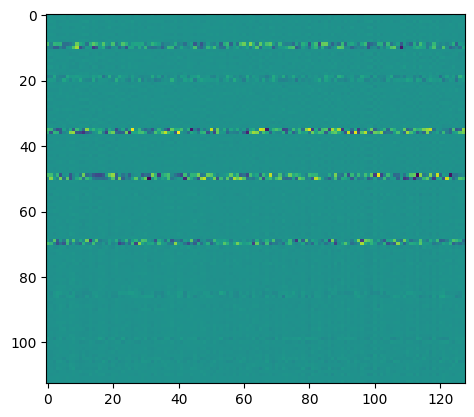

In [109]:
plt.imshow(fourier_basis @ W_E.detach().cpu())

Text(0.5, 0, 'Frequency')

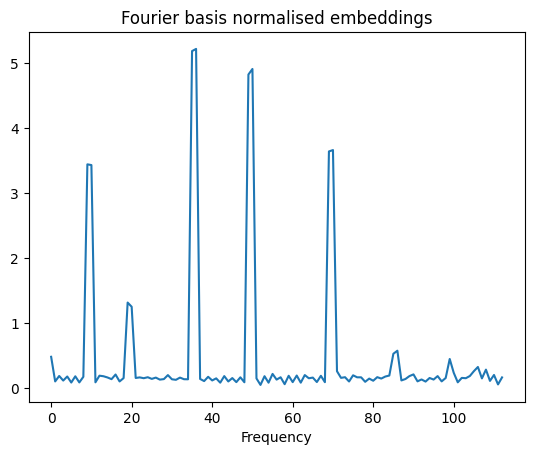

In [108]:
primary_values = fourier_basis @ W_E.detach().cpu()
normalised = primary_values.norm(dim = -1)
plt.plot(normalised)
plt.title("Fourier basis normalised embeddings")
plt.xlabel('Frequency')

In [ ]:
torch.topk(normalised.flatten(), 10).indices

# Train and find frequencies across primes

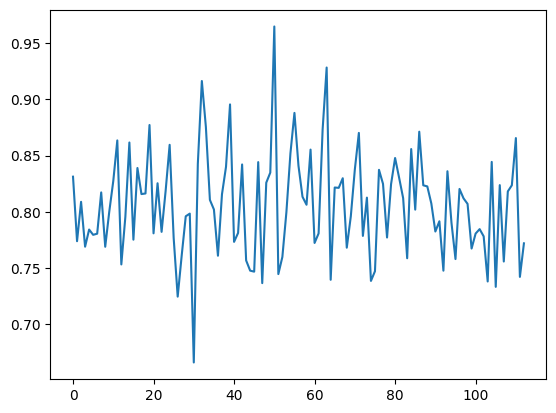

In [30]:
def find_key_frequencies(model,p):
  W_E = model.embed.W_E[:-1]
  fourier_basis = []
  fourier_basis_names = []
  fourier_basis.append(torch.ones(p-1))
  fourier_basis_names.append("Constant")
  for freq in range(1, p//2+1):
      fourier_basis.append(torch.sin(torch.arange(p-1)*2 * torch.pi * freq / p))
      fourier_basis_names.append(f"Sin {freq}")
      fourier_basis.append(torch.cos(torch.arange(p-1)*2 * torch.pi * freq / p))
      fourier_basis_names.append(f"Cos {freq}")
  #print(len(fourier_basis))
  fourier_basis = torch.stack(fourier_basis, dim=0)
  fourier_basis = fourier_basis/fourier_basis.norm(dim=-1, keepdim=True)
  primary_values = fourier_basis @ W_E.detach().cpu()
  normalised = primary_values.norm(dim = -1)
  return normalised


plt.plot(find_key_frequencies(model,113))

In [84]:
@timer
def train_model(p_in, seed, epochs, frac = 0.7):
  frac_train = frac#0.7
  p = p_in
  seed = seed
  lr = 1e-3
  wd = 1.
  betas = (0.9,0.98)

  a_vector = einops.repeat(torch.arange(p_in), "i -> (i j)", j=p_in)
  b_vector = einops.repeat(torch.arange(p_in), "j -> (i j)", i=p_in)
  dataset = torch.stack([a_vector, b_vector], dim=1).to(device)
  labels = (dataset[:, 0] + dataset[:, 1]) % p
  labels = labels.to(device)

  train_data, train_labels, test_data, test_labels = test_train_split(dataset, labels, seed, frac_train)
  train_data = train_data
  train_labels = train_labels
  test_data = test_data
  test_labels = test_labels
  cfg = HookedTransformerConfig(
      n_layers = 1,
      n_heads = 4,
      d_model = 128,
      d_head = 32,
      d_mlp = 512,
      act_fn = "relu",
      normalization_type=None,
      d_vocab=p,
      d_vocab_out=p,
      n_ctx=2,
      init_weights=True,
      device=device,#"cuda",
      seed = 999,
  )
  model = HookedTransformer(cfg)
  loss_function = loss_fn
  optimiser = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)

  for name, param in model.named_parameters():
      if "b_" in name:
          param.requires_grad = False

  run_test(test_data,test_labels,model)

  losses = []
  correct_in_test = []
  correct_in_train = []
  test_losses = []

  epochs = epochs
  n_show = 100
  n_train_loss = 50
  epochs_to_grok = 0
  start = time.time()
  for i in range(epochs):
      optimiser.zero_grad()
      yPrediction = torch.squeeze(model(train_data))
      #print(yPrediction.shape, train_labels.shape)
      #print(yPrediction[0],data[1][0])
      loss = loss_function(yPrediction, train_labels)
      loss.backward()
      optimiser.step()
      losses.append(loss.item())
    # print(yPrediction.shape)
    # print(train_labels.shape)
      if (i+1) % n_train_loss == 0:
        test_losses.append(loss_function(torch.squeeze(model(test_data)),test_labels).item())
      if (i+1) % n_show == 0:
          correct_in_test.append(run_test(test_data, test_labels,model))
          correct_in_train.append(run_test(train_data, train_labels,model))
          print('Epoch [{}/{}] of prime {} and seed {} in {:.2f}s, log loss of {:.3f}, train_set: {:.1f}%, test_set: {:.1f}%'.format(i+1,epochs,p_in,seed,time.time()-start,math.log(losses[-1]),100*correct_in_train[-1],100*correct_in_test[-1]))
          start = time.time()
          if (correct_in_test[-1] > 0.5) and epochs_to_grok == 0:
            epochs_to_grok = i

  return [model, losses, n_train_loss, test_losses, n_show, correct_in_test, correct_in_train, epochs_to_grok, seed, p]

# Across Seeds

In [32]:
p = 113
seed = 111
epochs = 200#00

outputs = []
for seed in [101,103,105, 107]:
  print('~~~~~~~~~~~ Running {}, {}, for {} epochs ~~~~~~~~~~~'.format(p,seed,epochs))
  outputs.append(train_model(p,seed,epochs))


~~~~~~~~~~~ Running 113, 101, for 200 epochs ~~~~~~~~~~~
The function "test_train_split" took 0.008s to run
Epoch [100/200] of prime 113 and seed 101 in 1.99s, log loss of 0.948, train_set: 34.8%, test_set: 0.0%
Epoch [200/200] of prime 113 and seed 101 in 1.71s, log loss of -2.815, train_set: 100.0%, test_set: 0.3%
The function "train_model" took 4.348s to run
~~~~~~~~~~~ Running 113, 103, for 200 epochs ~~~~~~~~~~~
The function "test_train_split" took 0.005s to run
Epoch [100/200] of prime 113 and seed 103 in 1.43s, log loss of 0.867, train_set: 40.9%, test_set: 0.0%
Epoch [200/200] of prime 113 and seed 103 in 1.42s, log loss of -3.165, train_set: 100.0%, test_set: 0.4%
The function "train_model" took 3.296s to run
~~~~~~~~~~~ Running 113, 105, for 200 epochs ~~~~~~~~~~~
The function "test_train_split" took 0.005s to run
Epoch [100/200] of prime 113 and seed 105 in 1.41s, log loss of 0.910, train_set: 38.3%, test_set: 0.0%
Epoch [200/200] of prime 113 and seed 105 in 1.42s, log loss

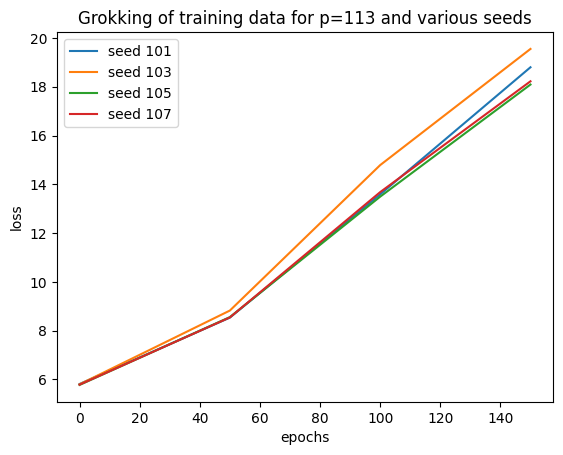

In [33]:

#[model, losses, n_train_loss, test_losses, n_show, correct_in_test, correct_in_train, epochs_to_grok, seed, p] = outputs[-1]
seeds = [101,103,105,107]
plt.figure()
for i in range(len(outputs)):
  m = outputs[i][0]
  losses = outputs[i][3]
#  plt.plot(find_key_frequencies(model,p))
  plt.plot([x*outputs[i][2] for x in range(len(losses))],(losses), label = 'seed {}'.format(seeds[i]))
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title('Grokking of training data for p=113 and various seeds')

#plt.title('Key Frequencies at {}, with seed {}'.format(p,seed))
############## remember log(113) is the random choice loss - these are much worse!

In [34]:
for i in range(len(outputs)):
  out = outputs[i]
  print('epochs to grok with seed {} was {}'.format(seeds[i],out[-3]+1))

epochs to grok with seed 101 was 1
epochs to grok with seed 103 was 1
epochs to grok with seed 105 was 1
epochs to grok with seed 107 was 1


Text(0.5, 1.0, 'Key frequencies for p=113 at various seeds')

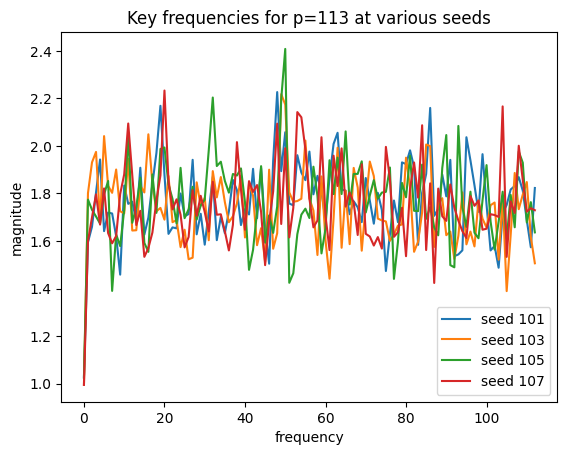

In [35]:
plt.figure()
keys = []
for i in range(len(outputs)):
  m = outputs[i][0]
  key = find_key_frequencies(m,113)
  keys.append(key)
  #losses = outputs[i][3]
#  plt.plot(find_key_frequencies(model,p))
  plt.plot(key, label = 'seed {}'.format(seeds[i]))
plt.legend()
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.title('Key frequencies for p={} at various seeds'.format(p))

In [36]:


for i in range(len(keys)):
  seed = seeds[i]
  key = keys[i]
  top_values, top_indices = torch.topk(key,12)
  print('p={}, seed={}'.format(p,seed))
  print('Top values',top_values)
  print('Top indices',top_indices)


p=113, seed=101
Top values tensor([2.2265, 2.1687, 2.1598, 2.0577, 2.0553, 2.0365, 2.0082, 1.9816, 1.9763,
        1.9702, 1.9654, 1.9609])
Top indices tensor([48, 19, 86, 50, 63, 95, 62, 81, 56, 18, 99, 53])
p=113, seed=103
Top values tensor([2.2179, 2.1740, 2.0489, 2.0413, 2.0225, 2.0059, 1.9994, 1.9924, 1.9749,
        1.9506, 1.9463, 1.9343])
Top indices tensor([49, 50, 16,  5, 55, 85, 86, 63,  3, 80, 11, 71])
p=113, seed=105
Top values tensor([2.4079, 2.2035, 2.1963, 2.0841, 2.0610, 2.0525, 2.0458, 1.9936, 1.9873,
        1.9815, 1.9765, 1.9591])
Top indices tensor([ 50,  32,  49,  93,  65,  11,  90,  20,  19,  31, 108,  81])
p=113, seed=107
Top values tensor([2.2330, 2.1662, 2.1423, 2.1205, 2.0943, 2.0938, 2.0869, 2.0366, 2.0160,
        2.0008, 1.9960, 1.9903])
Top indices tensor([ 20, 104,  53,  54,  11,  48,  84,  59,  38, 108,  75,  50])


# Across Primes

In [91]:
p = 113
seed = 1479
epochs = 10000

primes = [43,53,181,197]
primes = [43]
outputs = []
for p in primes:
  print('~~~~~~~~~~~ Running p={}, seed={}, for {} epochs ~~~~~~~~~~~'.format(p,seed,epochs))
  outputs.append(train_model(p,seed,epochs, 0.6))

~~~~~~~~~~~ Running p=43, seed=1479, for 10000 epochs ~~~~~~~~~~~
The function "test_train_split" took 0.002s to run
Epoch [100/10000] of prime 43 and seed 1479 in 0.73s, log loss of -3.005, train_set: 100.0%, test_set: 0.2%
Epoch [200/10000] of prime 43 and seed 1479 in 0.88s, log loss of -5.186, train_set: 100.0%, test_set: 0.3%
Epoch [300/10000] of prime 43 and seed 1479 in 0.63s, log loss of -6.380, train_set: 100.0%, test_set: 0.8%
Epoch [400/10000] of prime 43 and seed 1479 in 0.62s, log loss of -7.527, train_set: 100.0%, test_set: 1.4%
Epoch [500/10000] of prime 43 and seed 1479 in 0.62s, log loss of -8.651, train_set: 100.0%, test_set: 2.3%
Epoch [600/10000] of prime 43 and seed 1479 in 0.62s, log loss of -9.757, train_set: 100.0%, test_set: 2.6%
Epoch [700/10000] of prime 43 and seed 1479 in 0.64s, log loss of -10.848, train_set: 100.0%, test_set: 3.2%
Epoch [800/10000] of prime 43 and seed 1479 in 0.63s, log loss of -11.913, train_set: 100.0%, test_set: 3.8%
Epoch [900/10000]

p=43 grokked in 4600 epochs


Text(0, 0.5, 'log loss')

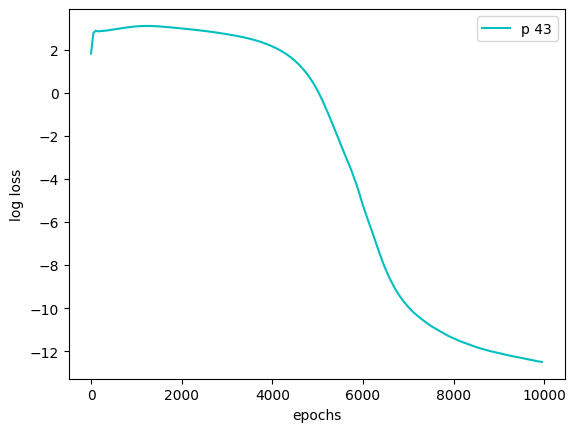

In [101]:

#[model, losses, n_train_loss, test_losses, n_show, correct_in_test, correct_in_train, epochs_to_grok, seed, p] = outputs[-1]
#primes = [73,89,103,109,127,139]
plt.figure()
colors = {73:'r',89:'b',103:'g',109:'y',127:'k',139:'c'}
colors = {43:'c',53:'r',181:'g',197:'b'}
for i in range(len(outputs)):
  m = outputs[i][0]
  losses = outputs[i][3]
  print('p={} grokked in {} epochs'.format(outputs[i][-1],outputs[i][-3]+1))
#  plt.plot(find_key_frequencies(model,p))
  plt.plot([x*outputs[i][2] for x in range(len(losses))],np.log(losses), label = 'p {}'.format(outputs[i][-1]), color = colors[outputs[i][-1]])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel('epochs')
plt.ylabel('log loss')
#plt.title('Grokking of training data for various primes and seeds')

Text(0, 0.5, 'magnitude')

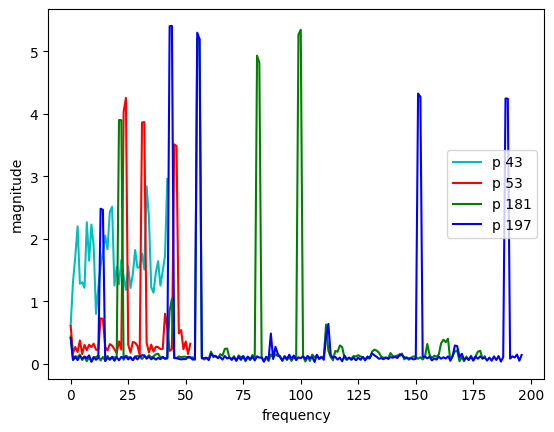

In [81]:
plt.figure()
keys = []
#primes = [101,103,107,109,113,127]
for i in range(len(outputs)):
  m = outputs[i][0]
  key = find_key_frequencies(m,outputs[i][-1])
  keys.append(key)
  #losses = outputs[i][3]
  plt.plot(key, label = 'p {}'.format(outputs[i][-1]),color = colors[outputs[i][-1]])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel('frequency')
plt.ylabel('magnitude')
#plt.title('Key frequencies for p={} at various seeds'.format(p))

In [82]:

for i in range(len(keys)):
  seed = 111
  key = keys[i]
  top_values, top_indices = torch.topk(key,12)
  print('p={}, seed={}'.format(outputs[i][-1],outputs[i][-2]))
  print('Top values',top_values)
  print('Top indices',top_indices)


p=43, seed=1479
Top values tensor([2.9587, 2.8388, 2.5129, 2.4303, 2.3516, 2.2665, 2.2284, 2.2000, 2.0516,
        1.8778, 1.8354, 1.8218])
Top indices tensor([42, 33, 18, 17, 34,  7,  9,  3, 15, 10, 16, 28])
p=53, seed=1479
Top values tensor([4.2523, 4.0275, 3.8662, 3.8602, 3.5108, 3.4825, 0.8034, 0.7299, 0.7228,
        0.6047, 0.5859, 0.5430])
Top indices tensor([24, 23, 32, 31, 45, 46, 41, 13, 14,  0, 42, 48])
p=181, seed=1479
Top values tensor([5.3418, 5.2643, 5.1973, 5.1939, 4.9278, 4.8149, 3.9003, 3.8971, 1.0415,
        0.8484, 0.6314, 0.4401])
Top indices tensor([100,  99,  55,  56,  81,  82,  21,  22,  44,  43, 111,   0])
p=197, seed=1479
Top values tensor([5.4031, 5.3990, 5.2946, 5.1916, 4.3220, 4.2698, 4.2439, 4.2401, 2.4819,
        2.4640, 0.6406, 0.4871])
Top indices tensor([ 44,  43,  55,  56, 151, 152, 189, 190,  13,  14, 112,  87])
